# Figure 1 - experiment

* Raw image from microscopy and PIV, low concentration
* Raw image from microscopy and PIV, high concentration
* Correlation between velocity magnitude and light intensity

## 1. Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from myImageLib import dirrec, bestcolor, bpass, wowcolor
from skimage import io, measure
import pandas as pd
from scipy.signal import savgol_filter, medfilt
import os
from corrLib import corrS, corrI, divide_windows, distance_corr, corrIseq, readseq, match_hist
from scipy.signal import savgol_filter
import matplotlib as mpl
from numpy.polynomial.polynomial import polyvander
from scipy.optimize import curve_fit
from miscLib import label_slope
from corrLib import density_fluctuation
from scipy import signal
from matplotlib.patches import Rectangle
import pandas as pd

## 2. Scalebar

Here I want to implement a function which can determine the length and position of scalebar automatically, if image dimension is given. 

**The guideline is:**

- The width of the scalebar is 1/5 of the image width
- the height of the scalebar is 1/10 of its width
- place scalebar at the bottom right corner, width right margin and bottom margin both its height
- (hard, optional) round actually length of scalebar to multiples of 10, 100 if close

### 2.1 Get shape and position

In [2]:
def scalebar_shape_position(img_shape):
    """
    Args:
    img_shape -- tuple of 2 integers, (h_i, w_i)
    
    Returns:
    scalebar_shape -- tuple of 2 intergers, (h_s, w_s)
    position -- tuple of 2 integers (top left of scalebar), (x, y)
    """
    h, w = img_shape
    shape = (int(w/50), int(w/5))
    margin = shape[0]
    xy = (w - shape[1] - margin, h - shape[0] - margin)
    return shape, xy

In [3]:
img_shape = (800, 1000)
shape, xy = scalebar_shape_position(img_shape)
print("position: " + str(xy) + '\nshape: ' + str(shape))

position: (780, 760)
shape: (20, 200)


### 2.2 Draw scalebar on given axis

Now that we have determined the shape and position of the scalebar, we can move on to draw it on the image.

In [3]:
def draw_scalebar(ax, shape, xy):
    """
    Args:
    ax -- the axis on which image is shown
    shape -- shape of scalebar
    xy -- position of scalebar
    
    Returns:
    None
    """
    
    h, w = shape
    rect = Rectangle(xy, w, h, color='white')
    ax.add_patch(rect)
    
    return None

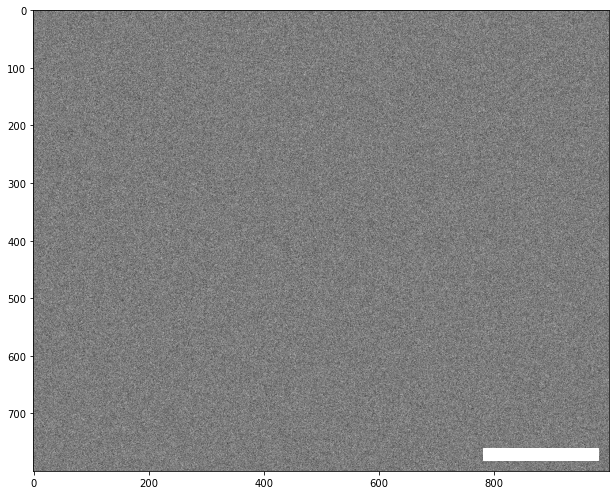

In [5]:
img = np.random.randn(800, 1000)
fig = plt.figure(figsize=(8, 10))
ax = fig.add_axes([0, 0, 1, 1])
ax.imshow(img, cmap='gray')
img_shape = img.shape
shape, xy = scalebar_shape_position(img_shape)
draw_scalebar(ax, shape, xy)

## 3. High concentration - Dynamics_raw - 80 n$_0$

In [16]:
output_folder = r'E:\Google Drive\Research projects\DF\Figures\fig1-experiment\out'

### 3.1 Raw image

In [4]:
img = io.imread(r'I:\Google Drive\Research projects\DF\Figures\fig1-experiment\raw\80-900.tif')
h, w = img.shape
wf = 1.57
hf = h / w * wf

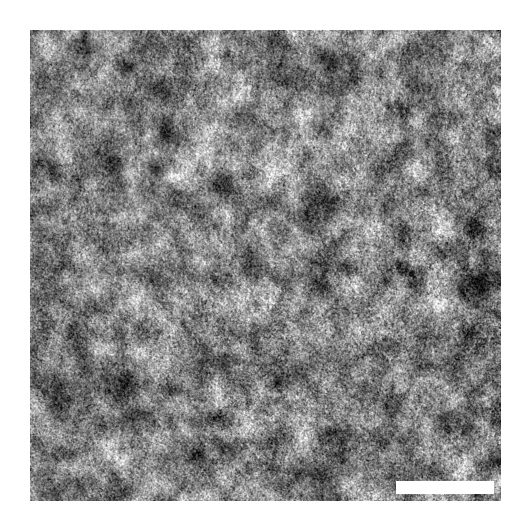

In [18]:
img = io.imread(r'E:\Google Drive\Research projects\DF\Figures\fig1-experiment\raw\80-900.tif')
fig = plt.figure(figsize=(hf, wf), dpi = 300)
ax = fig.add_axes([0, 0, 1, 1])
ax.imshow(img, cmap='gray')
ax.axis('off')
shape, xy = scalebar_shape_position(img.shape)
draw_scalebar(ax, shape, xy)
fig.savefig(os.path.join(output_folder, '80_raw.png'))

In [8]:
# scalebar length
mpp = 0.33 # um/px
scalebar_length = shape[1] * mpp
print('scalebar length: {:d} um'.format(round(scalebar_length)))

scalebar length: 135 um


### 3.2 PIV overlay

(-73.75, 2098.75, -73.75, 2098.75)

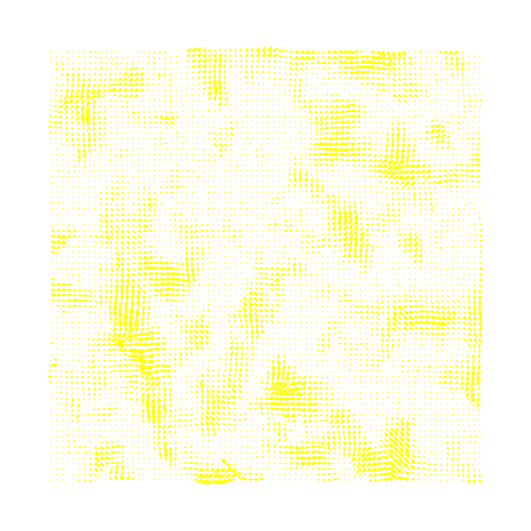

In [9]:
pivData = pd.read_csv(r'E:\Google Drive\Research projects\DF\Figures\fig1-experiment\raw\80-900-piv.csv')
fig = plt.figure(figsize=(hf, wf), dpi = 300)
ax = fig.add_axes([0, 0, 1, 1])
ax.quiver(pivData.x, pivData.y, pivData.u, pivData.v, color='yellow', width=0.003)
ax.axis('off')

**Sparcify the velocity field**

Right now the velocity field is too dense. We look to reduce the density a little bit. 

In [14]:
def sparcify_piv(pivData, sparcity=2):
    """
    Args:
    pivData -- DataFrame (x, y, u, v)
    sparcity -- int, degree to which pivData is sparcified, higher is sparcer
    
    Returns:
    sparcified_pivData -- DataFrame (x, y, u, v)
    """
    temp = {}
    col = len(pivData.x.drop_duplicates())
    row = len(pivData.y.drop_duplicates())
    for c in pivData:
        temp[c] = np.array(pivData[c]).reshape(row, col)[0:row:sparcity, 0:col:sparcity].flatten()
    sparcified_pivData = pd.DataFrame(temp)
    
    return sparcified_pivData

In [11]:
pivData = pd.read_csv(r'E:\Google Drive\Research projects\DF\Figures\fig1-experiment\raw\80-900-piv.csv')
sparcified_pivData = sparcify_piv(pivData, sparcity=2)
print('pivData:\n ' + str(pivData.head()) + '\n\nsparcified_pivData:\n ' + str(sparcified_pivData.head()))

pivData:
        x     y          u          v
0   25.0  25.0 -20.488350 -15.857035
1   50.0  25.0  -4.672327 -11.717124
2   75.0  25.0   2.746350 -27.942786
3  100.0  25.0  -4.345615 -22.511069
4  125.0  25.0  -4.022208 -17.712259

sparcified_pivData:
        x     y          u          v
0   25.0  25.0 -20.488350 -15.857035
1   75.0  25.0   2.746350 -27.942786
2  125.0  25.0  -4.022208 -17.712259
3  175.0  25.0  31.250867 -42.393437
4  225.0  25.0  11.291646 -26.665198


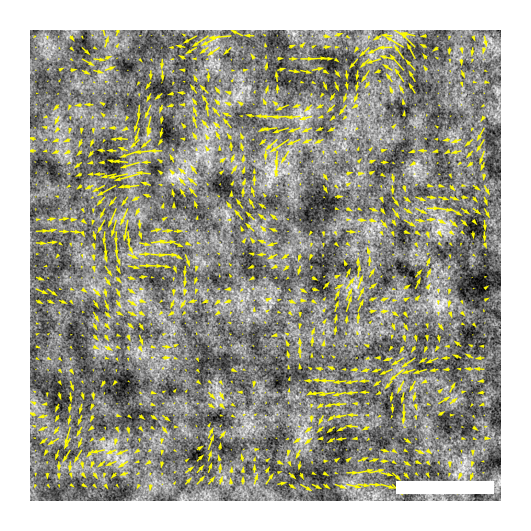

In [21]:
img = io.imread(r'E:\Google Drive\Research projects\DF\Figures\fig1-experiment\raw\80-900.tif')
pivData = pd.read_csv(r'E:\Google Drive\Research projects\DF\Figures\fig1-experiment\raw\80-900-piv.csv')
sparcified_pivData = sparcify_piv(pivData, sparcity=2)
fig = plt.figure(figsize=(hf, wf), dpi = 300)
ax = fig.add_axes([0, 0, 1, 1])
ax.imshow(img, cmap='gray')
ax.quiver(sparcified_pivData.x, sparcified_pivData.y, sparcified_pivData.u, sparcified_pivData.v, color='yellow', width=0.003)
ax.axis('off')
shape, xy = scalebar_shape_position(img.shape)
draw_scalebar(ax, shape, xy)
fig.savefig(os.path.join(output_folder, '80_piv.png'))

## 4. Low concentration - Dynamics_raw - 40 n$_0$

### 4.1 Raw image

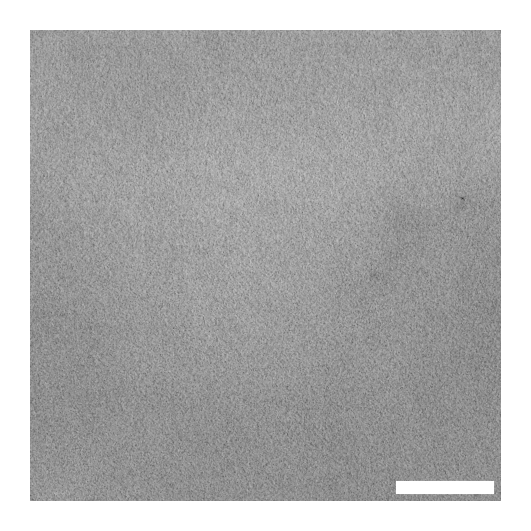

In [13]:
# Calculate figsize
img = io.imread(r'E:\Google Drive\Research projects\DF\Figures\fig1-experiment\raw\40-900.tif')
h, w = img.shape
wf = 1.57
hf = h / w * wf

fig = plt.figure(figsize=(hf, wf), dpi = 300)
ax = fig.add_axes([0, 0, 1, 1])
ax.imshow(img, cmap='gray')
ax.axis('off')
shape, xy = scalebar_shape_position(img.shape)
draw_scalebar(ax, shape, xy)

### 4.2 PIV overlay

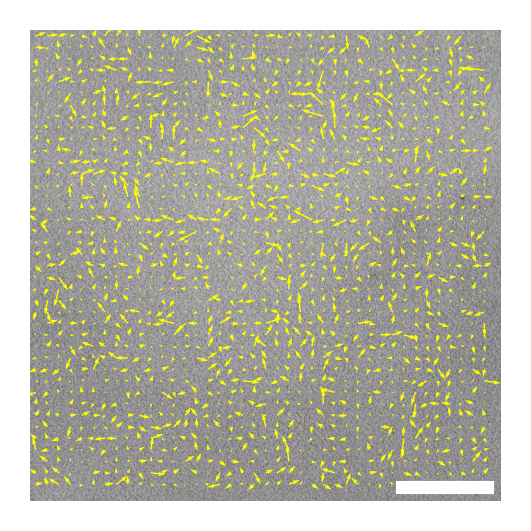

In [22]:
# Calculate figsize
img = io.imread(r'E:\Google Drive\Research projects\DF\Figures\fig1-experiment\raw\40-900.tif')
pivData = pd.read_csv(r'E:\Google Drive\Research projects\DF\Figures\fig1-experiment\raw\40-900-piv.csv')
sparcified_pivData = sparcify_piv(pivData, sparcity=2)
h, w = img.shape
wf = 1.57
hf = h / w * wf

fig = plt.figure(figsize=(hf, wf), dpi = 300)
ax = fig.add_axes([0, 0, 1, 1])
ax.imshow(img, cmap='gray')
ax.quiver(sparcified_pivData.x, sparcified_pivData.y, sparcified_pivData.u, sparcified_pivData.v, color='yellow', width=0.003)
ax.axis('off')
shape, xy = scalebar_shape_position(img.shape)
draw_scalebar(ax, shape, xy)
fig.savefig(os.path.join(output_folder, '40_piv.png'))

## 5 High resolution

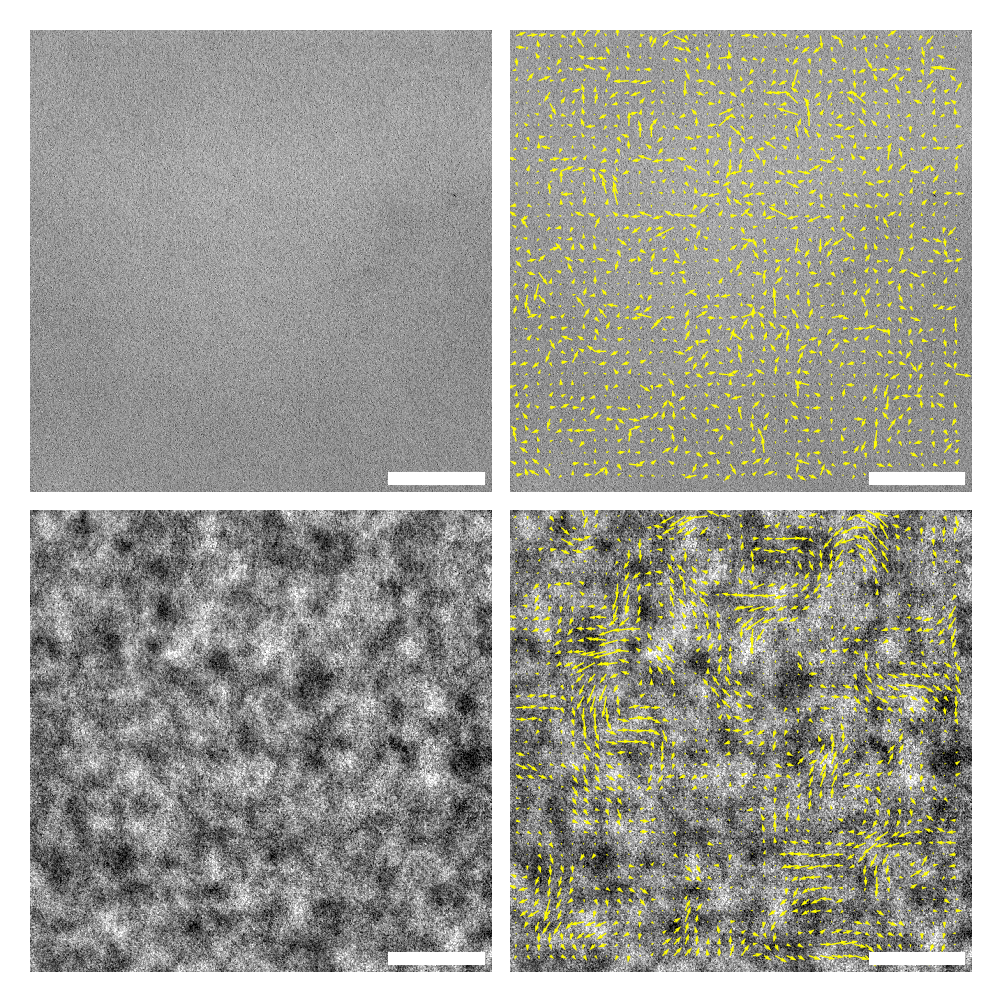

In [35]:
fig = plt.figure(figsize=(2*hf, 2*wf), dpi = 300)

img = io.imread(r'I:\Google Drive\Research projects\DF\Figures\fig1-experiment\raw\40-900.tif')
pivData = pd.read_csv(r'I:\Google Drive\Research projects\DF\Figures\fig1-experiment\raw\40-900-piv.csv')
sparcified_pivData = sparcify_piv(pivData, sparcity=2)
ax0 = fig.add_axes([0, 0.51, 0.49, 0.49])
ax0.imshow(img, cmap='gray')
ax0.axis('off')
shape, xy = scalebar_shape_position(img.shape)
draw_scalebar(ax0, shape, xy)

ax1 = fig.add_axes([0.51, 0.51, 0.49, 0.49])
ax1.imshow(img, cmap='gray')
ax1.quiver(sparcified_pivData.x, sparcified_pivData.y, sparcified_pivData.u, sparcified_pivData.v, color='yellow', width=0.003)
ax1.axis('off')
shape, xy = scalebar_shape_position(img.shape)
draw_scalebar(ax1, shape, xy)

img = io.imread(r'I:\Google Drive\Research projects\DF\Figures\fig1-experiment\raw\80-900.tif')
pivData = pd.read_csv(r'I:\Google Drive\Research projects\DF\Figures\fig1-experiment\raw\80-900-piv.csv')
sparcified_pivData = sparcify_piv(pivData, sparcity=2)
ax2 = fig.add_axes([0, 0, 0.49, 0.49])
ax2.imshow(img, cmap='gray')

ax2.axis('off')
shape, xy = scalebar_shape_position(img.shape)
draw_scalebar(ax2, shape, xy)

ax3 = fig.add_axes([0.51, 0, 0.49, 0.49])
ax3.imshow(img, cmap='gray')
ax3.quiver(sparcified_pivData.x, sparcified_pivData.y, sparcified_pivData.u, sparcified_pivData.v, color='yellow', width=0.003)
ax3.axis('off')
shape, xy = scalebar_shape_position(img.shape)
draw_scalebar(ax3, shape, xy)

output_folder = r'I:\Google Drive\Research projects\DF\Figures\fig1-experiment'
fig.savefig(os.path.join(output_folder, 'fig-1-HQ.pdf'), fmt='pdf')

In [32]:
shape[1]*0.325

132.925

In [26]:
img.shape

(2048, 2048)